In [40]:
#################################################################### Loading packages ####################################################################
%matplotlib inline
from scipy.optimize import dual_annealing
import numpy as np
import scipy.stats as scs
from matplotlib import pyplot as plt
from sklearn.gaussian_process.kernels import Matern
from collections import Counter
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim
from tqdm import tqdm
from datetime import datetime
import itertools
from itertools import permutations
from scipy.spatial import distance_matrix
import matplotlib
import matplotlib.colors as mcolors
from sklearn import metrics
import pickle
from joblib import Parallel, delayed
import psutil
import math

#################################################################### Loading GNM ####################################################################
model_version = 7
target_distribution = "gamma_hurdle"
base_nn = "HConvLSTM_tdscale"
sys.path.append('../')
import glms
import pickle
import torch
path_ = f"Checkpoints/uk_rain_DGLM_{base_nn}_{target_distribution}/lightning_logs/version_{model_version}/"
ckpt_path = glms.NeuralDGLM.get_ckpt_path(os.path.join(path_,"checkpoints"))
print([path_,ckpt_path])
scaler_features, scaler_target = glms.NeuralDGLM.load_scalers(path_)
model = glms.NeuralDGLM.load_from_checkpoint(ckpt_path, save_hparams=False, scaler_features=scaler_features, scaler_target=scaler_target)
model.freeze()
model.eval()

GNM_output = pickle.load( open(os.path.join(path_,"test_output_2014_2019-07.pkl"),"rb") )
location_keys = list(GNM_output.keys())                 # 'lat_58.95_57.35_lon_-6.55_-4.95', ...
output_keys = list(GNM_output[location_keys[0]].keys()) # 0'pred_mu', 1'pred_disp', 2'target_did_rain', 3'target_rain_value', 4'date', 5'pred_p', 6'mask', 7'idx_loc_in_region'

#################################################################### Utility functions ####################################################################
def give_lat_lon(location_key):
    return [float(location_key.split('_')[i]) for i in [1,2,4,5]]

def is_loc_land(location,row,column):
    return GNM_output[location]['mask'][0][0][row][column]


location_keys.remove('lat_50.95_49.35_lon_-4.55_-2.95') # 'lat_50.95_49.35_lon_-4.55_-2.95' has no data after week indexed 255, so I did not consider it.
day_dates = GNM_output[location_keys[100]]['date']
output_keys.remove('idx_loc_in_region') # not usefull
output_keys.remove('date') # no more usefull

#################################################################### Making list for land locations ####################################################################
#GNM_landonly[location][param][day]
# 0'pred_mu', 1'pred_disp', 2'target_did_rain', 3'target_rain_value', 4'pred_p', 5'location'

GNM_landonly = [] 
land_counter = -1
for location in tqdm(location_keys):
    for col in range(4):
        for row in range(4):
            if not is_loc_land(location,row,col):#check if land
                continue  
            land_counter+=1
            GNM_landonly.append([[],[],[],[],[]])
            temp_lat_lon = give_lat_lon(location)
            GNM_landonly[land_counter].append([round(temp_lat_lon[0]-0.6-row*0.1,2),round(temp_lat_lon[2]+0.6+col*0.1,2)])
            for param_idx,param in enumerate(output_keys[:-1]):
                for week in range(286):
                    for day in range(7):
                        GNM_landonly[land_counter][param_idx].append(GNM_output[location][param][week][day][row,col])

#################################################################### Preparing map ####################################################################
m = Basemap(projection='mill',
            resolution='i',llcrnrlat = 49,
            llcrnrlon = -12,
            urcrnrlat = 60,
            urcrnrlon = 3)
            
m_loc_4087 = [[0,1] for i in range(len(GNM_landonly))]
for i in range(len(GNM_landonly)):
    m_loc_4087[i][0] = m(3,GNM_landonly[i][5][0])[1]
    m_loc_4087[i][1] = m(GNM_landonly[i][5][1],3)[0]
  

['Checkpoints/uk_rain_DGLM_HConvLSTM_tdscale_gamma_hurdle/lightning_logs/version_7/', 'Checkpoints/uk_rain_DGLM_HConvLSTM_tdscale_gamma_hurdle/lightning_logs/version_7/checkpoints/epoch=12-step=25572-val_loss_loss=-0.391-val_metric_mse_rain=21.531.ckpt']


c:\Users\u1819911\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\u1819911\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
100%|██████████| 344/344 [00:25<00:00, 13.25it/s]


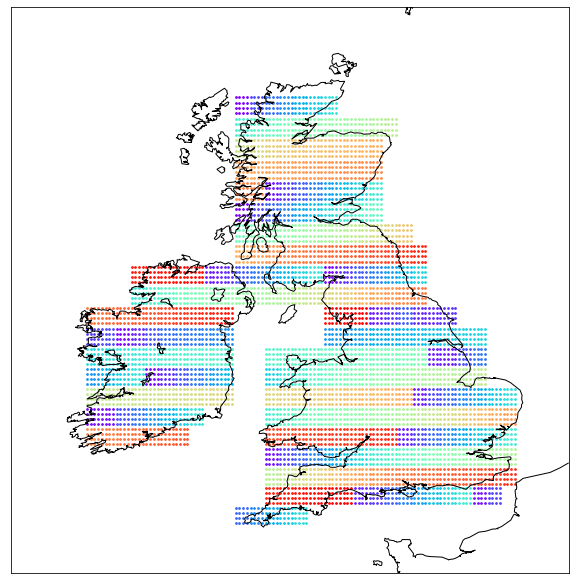

In [31]:
#locations on map 30s
fig = plt.gcf()
fig.set_size_inches(10, 20)
dpi=300
m.drawcoastlines()
color = matplotlib.pyplot.cm.rainbow(np.linspace(0, 1, len(GNM_landonly)))
for i in range(len(GNM_landonly)):
    m.scatter(x=m_loc_4087[i][1],y=m_loc_4087[i][0],color=color[i],s=3)

plt.show()

150


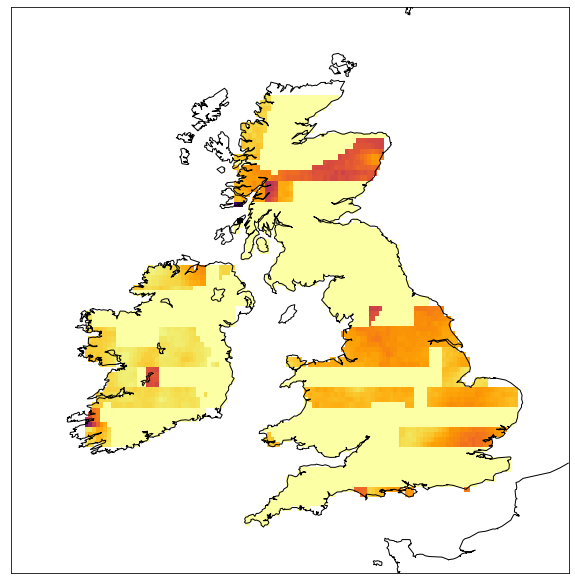

151


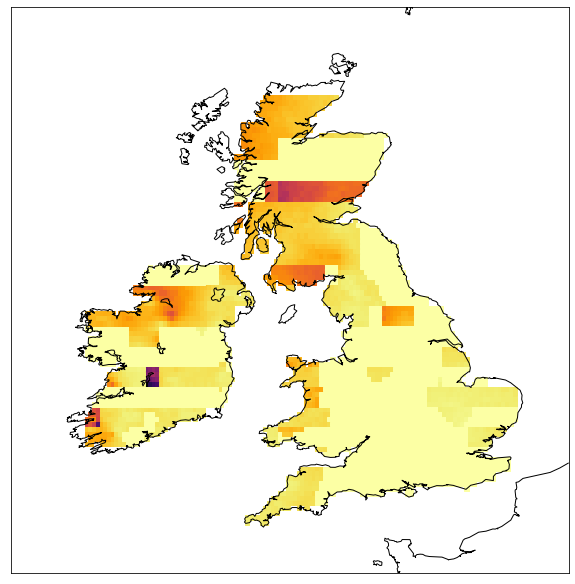

152


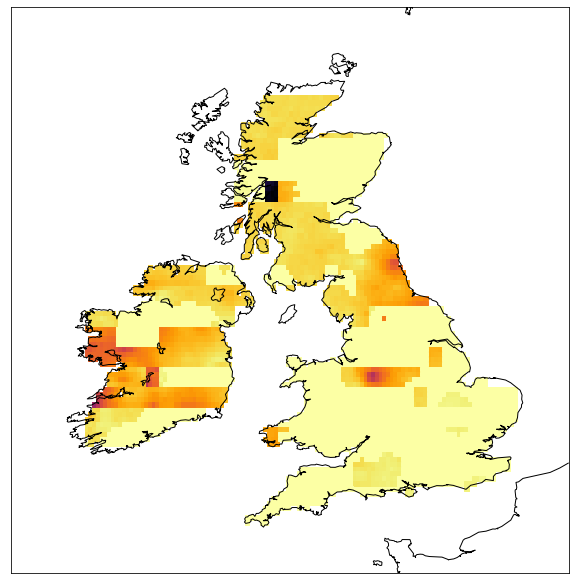

153


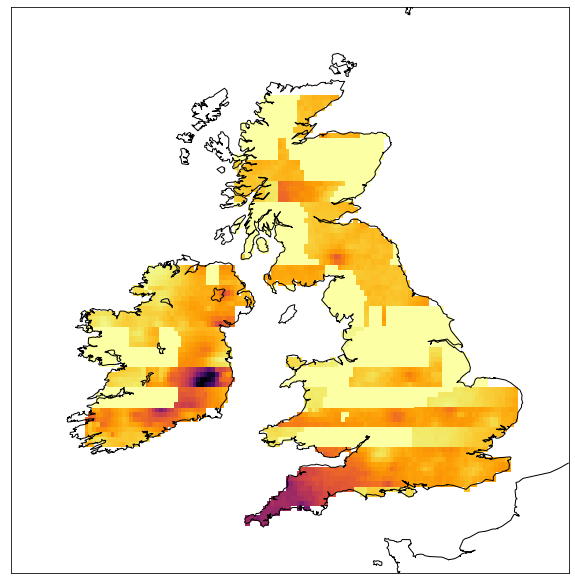

154


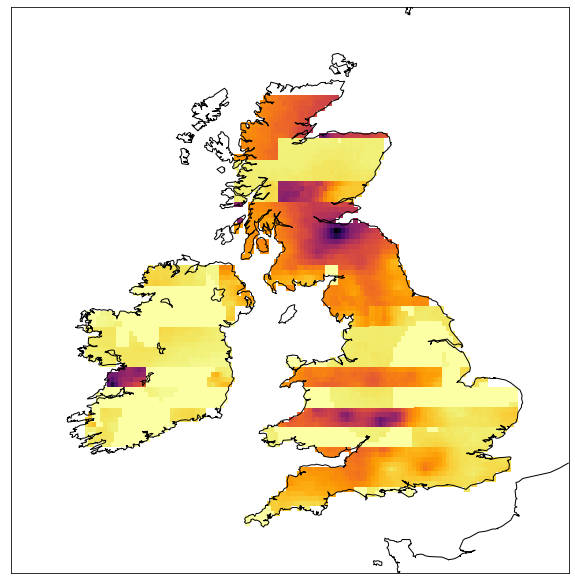

155


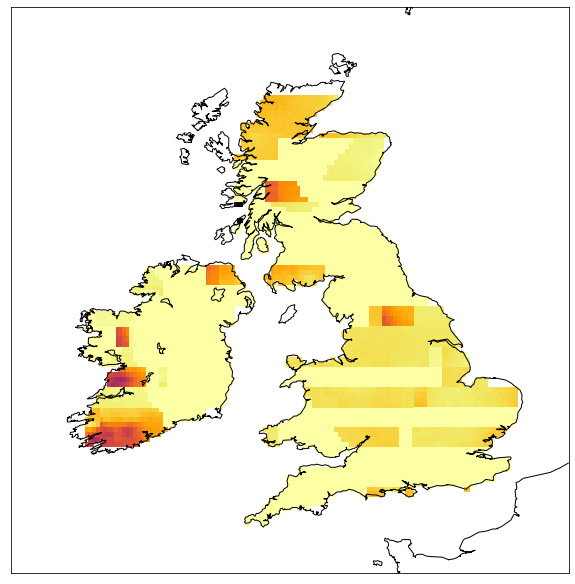

156


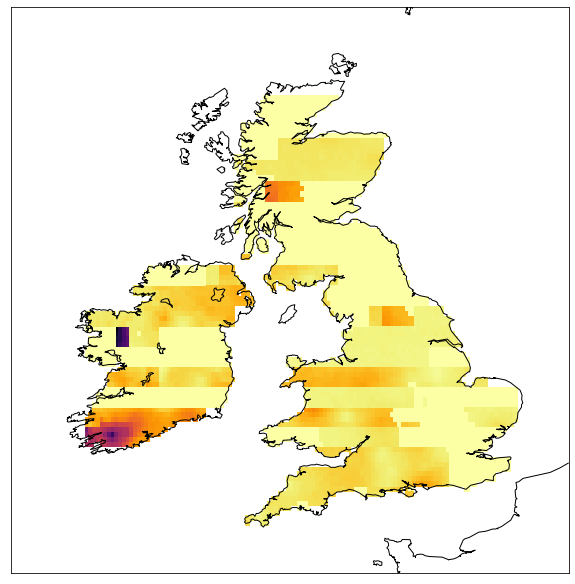

157


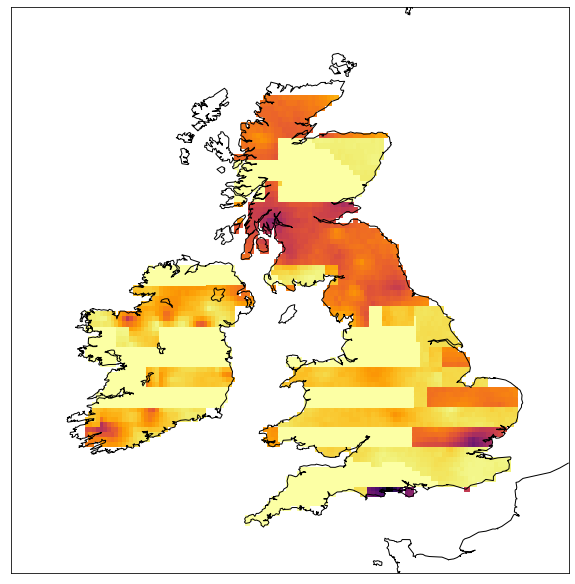

158


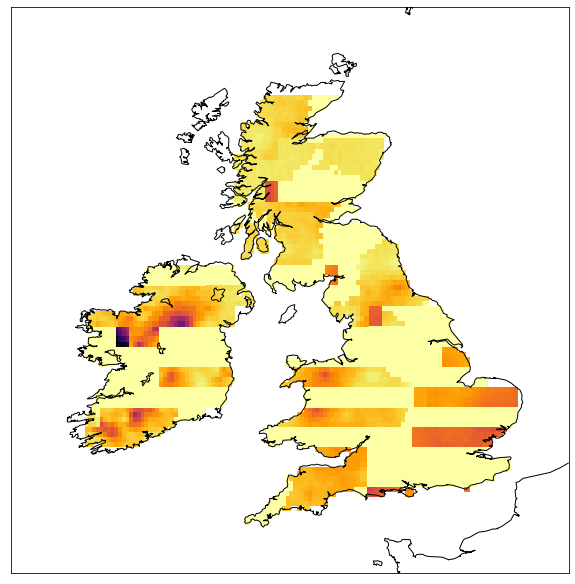

159


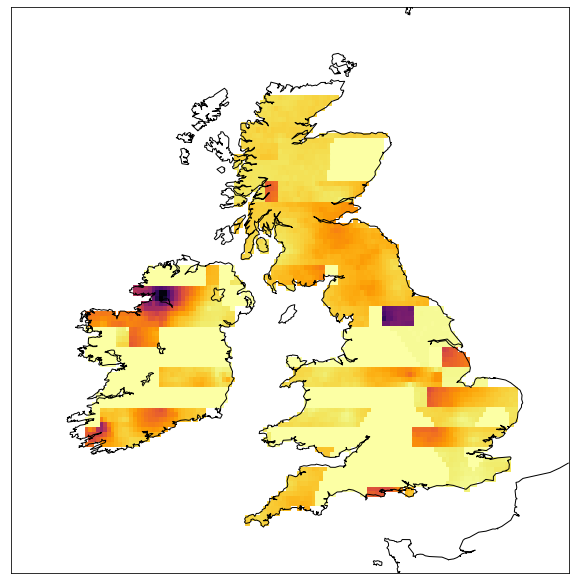

160


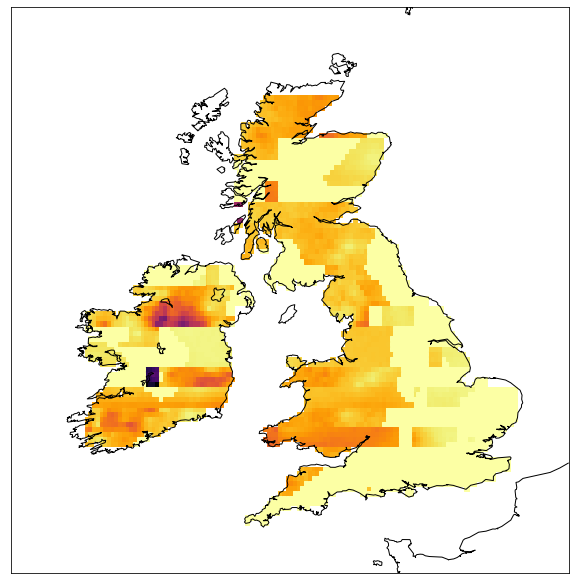

161


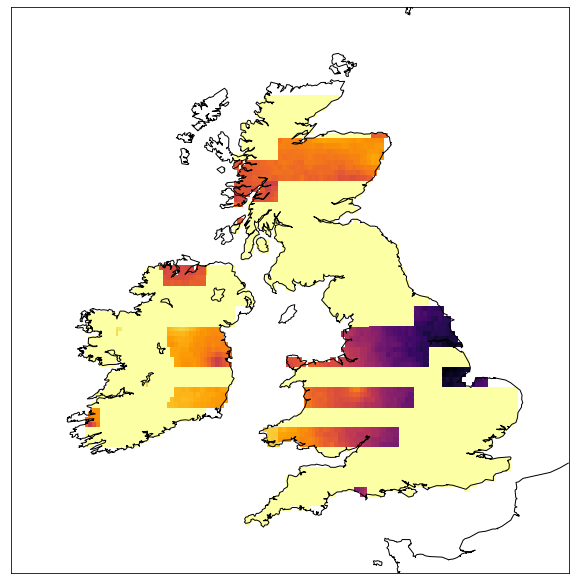

162


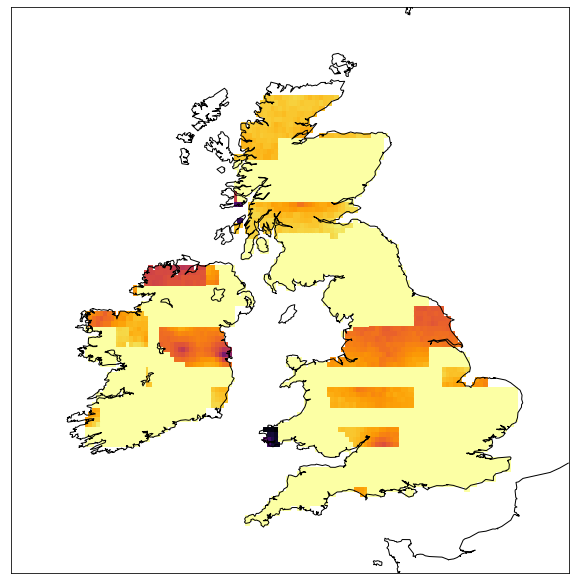

163


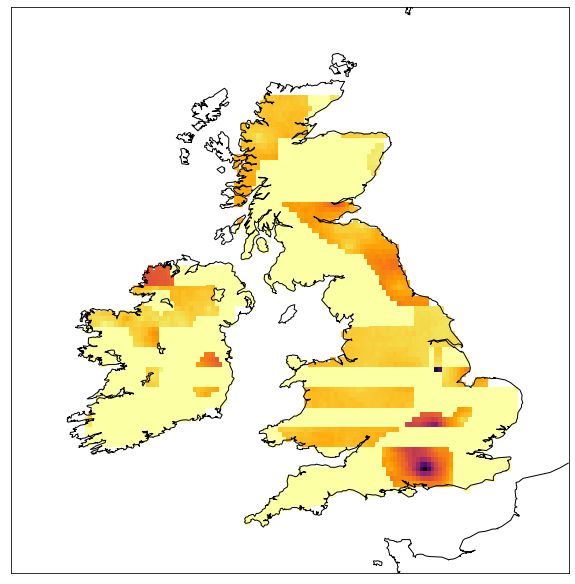

164


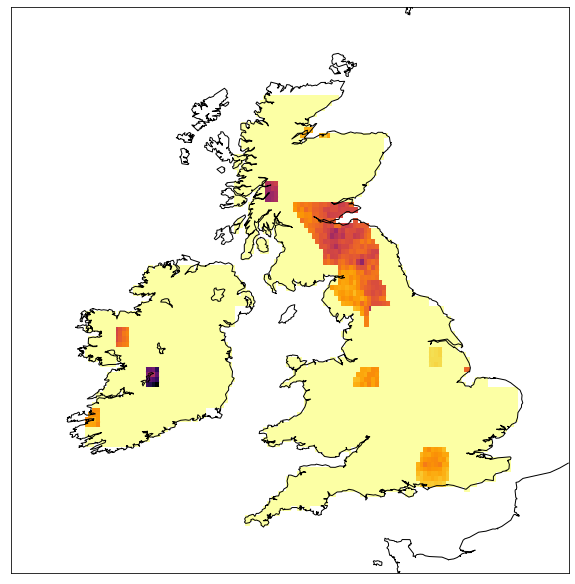

165


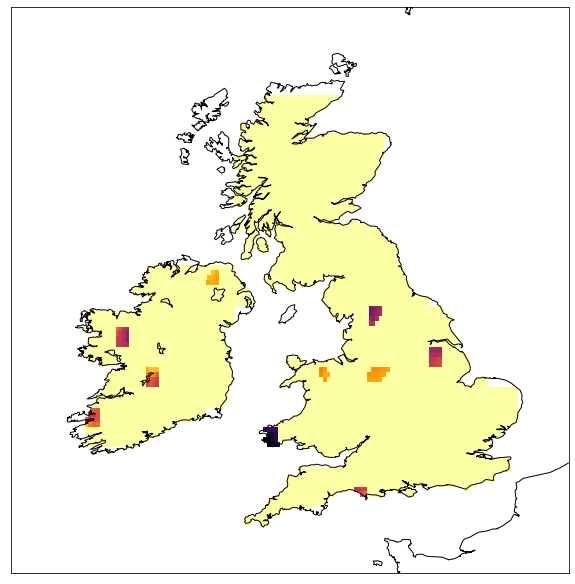

166


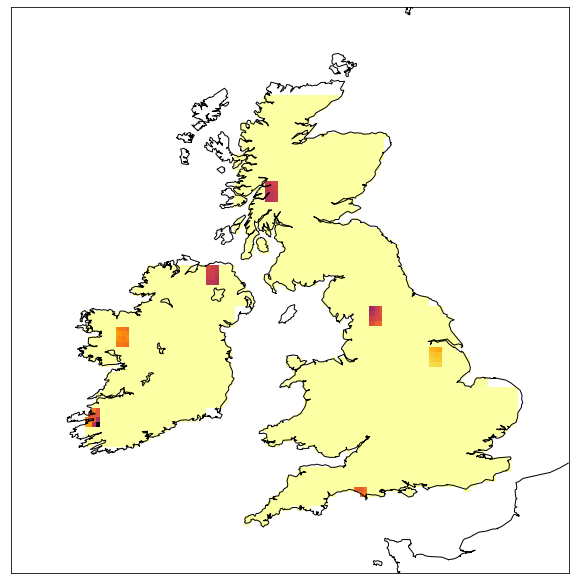

167


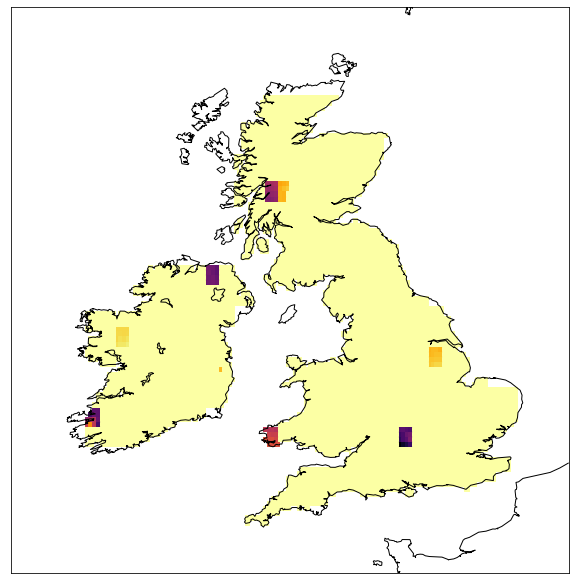

168


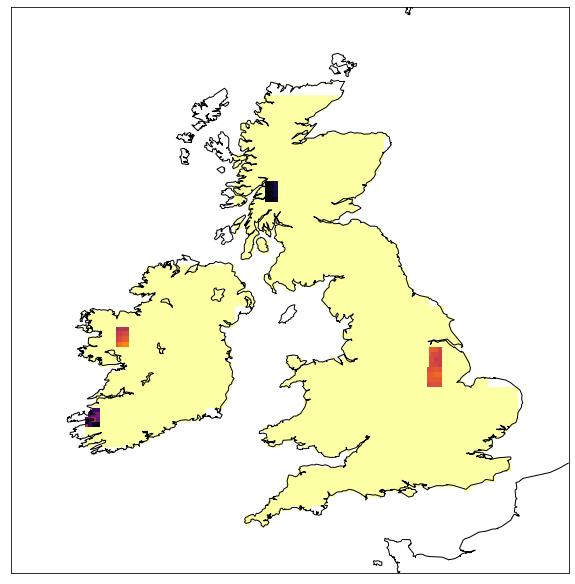

169


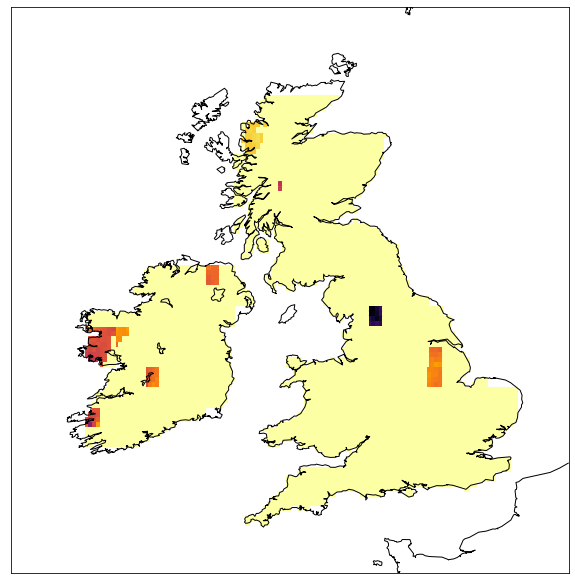

170


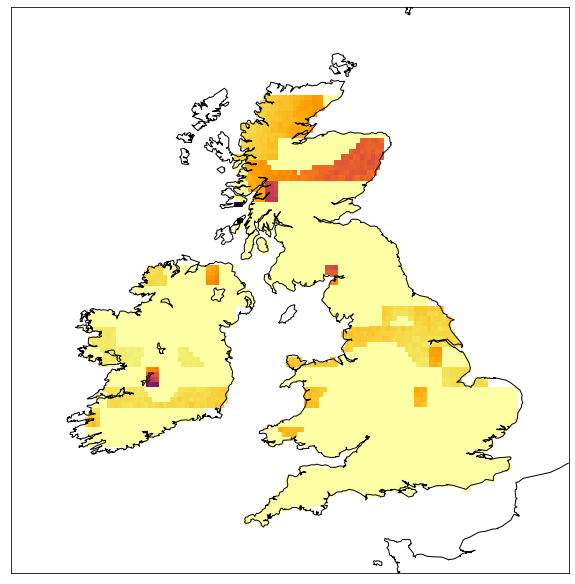

171


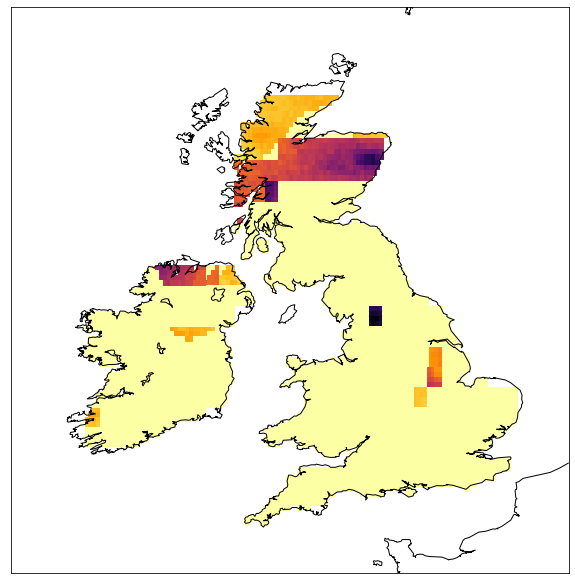

172


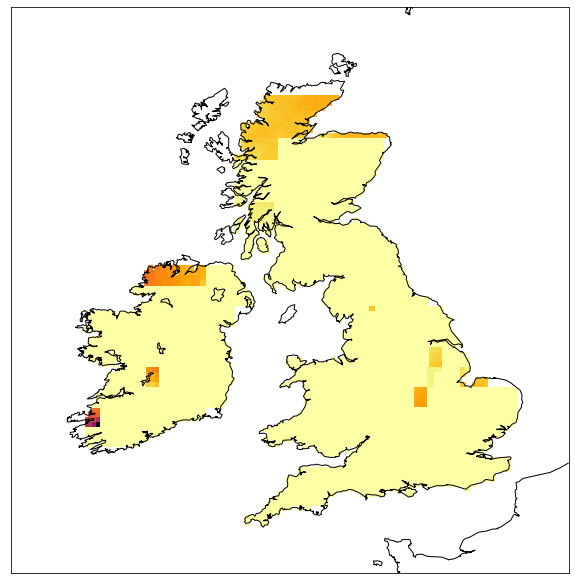

173


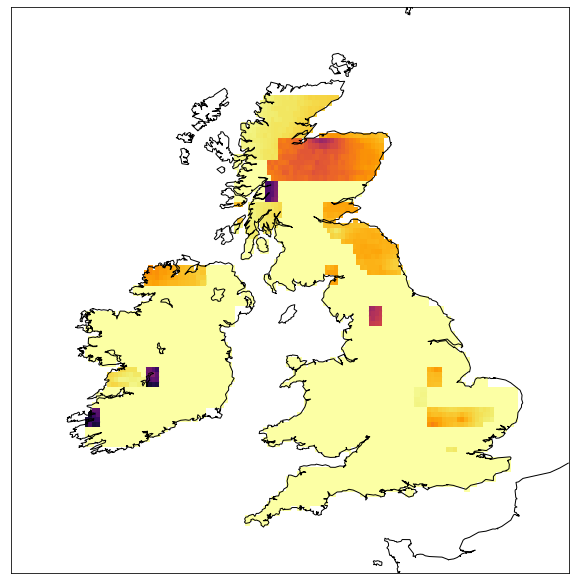

174


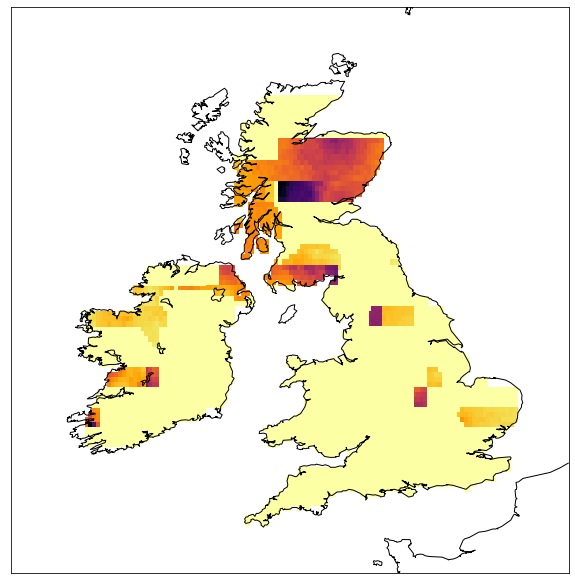

175


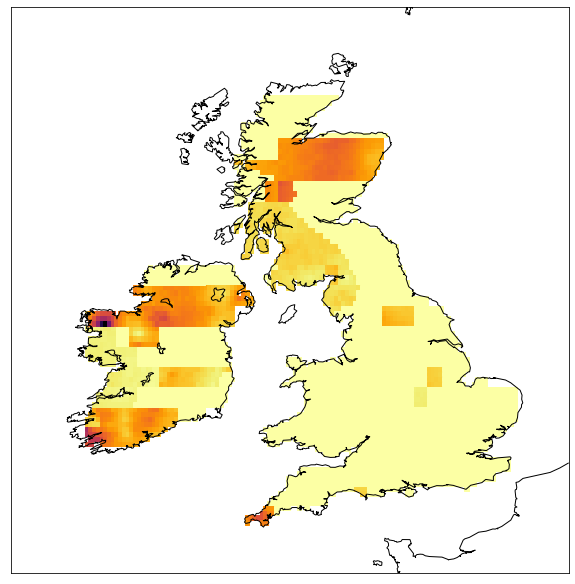

176


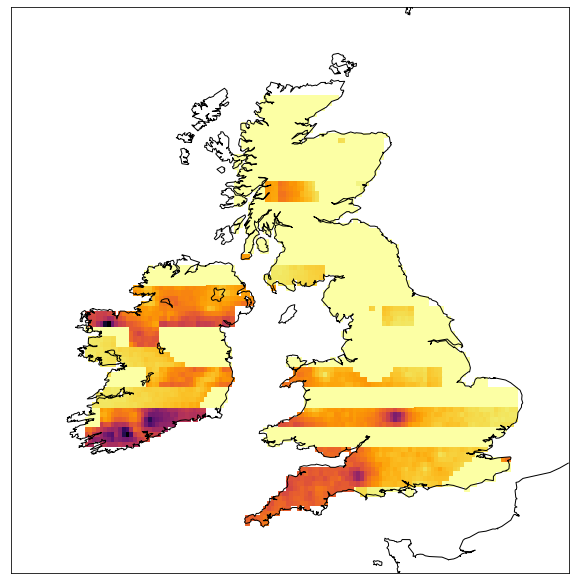

177


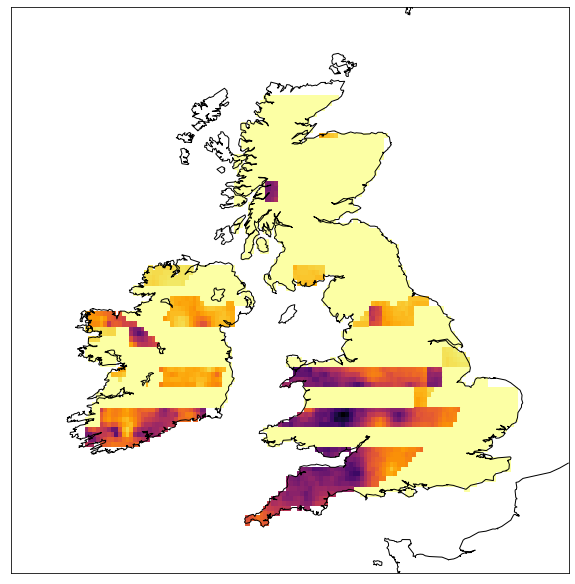

178


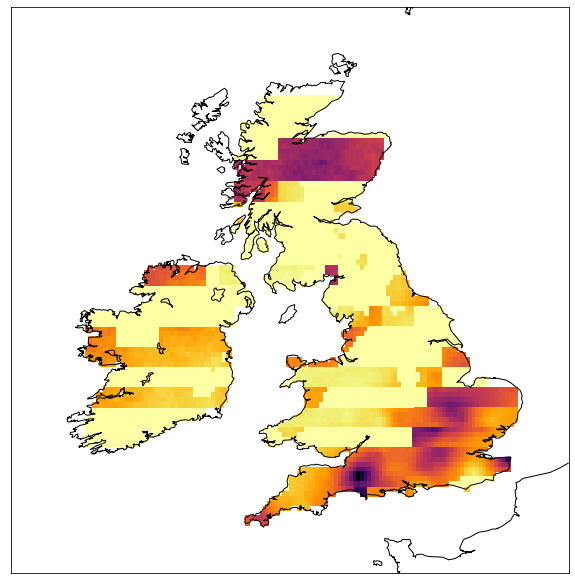

179


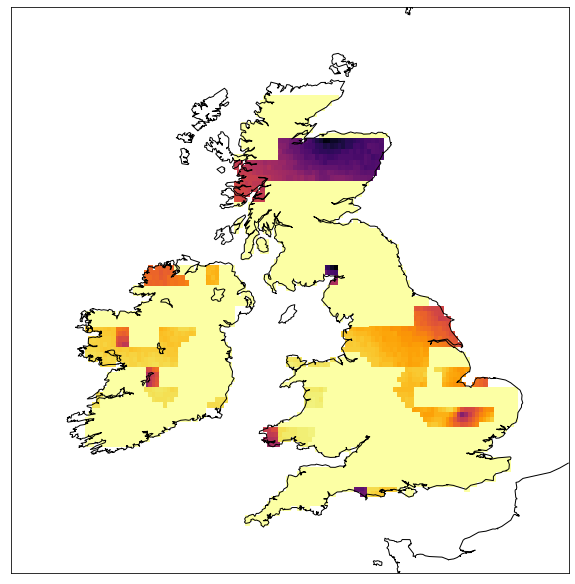

180


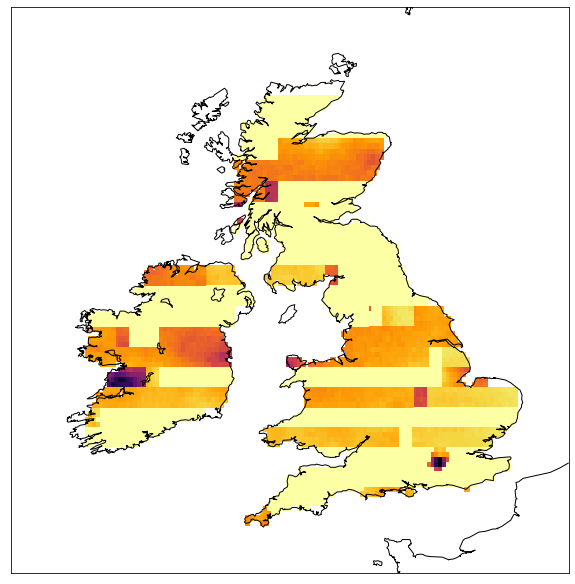

181


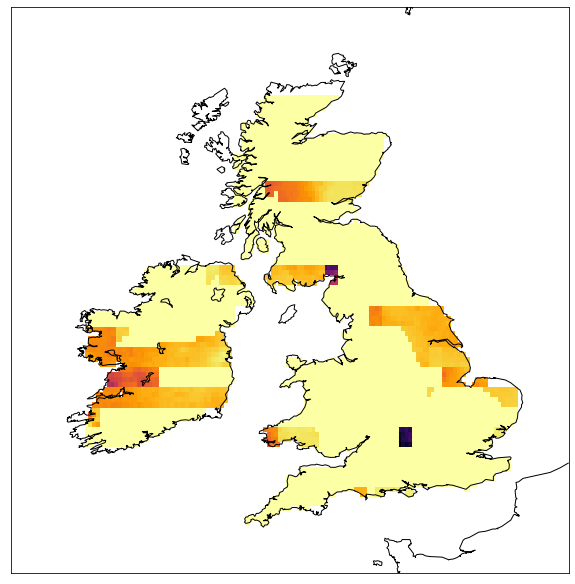

182


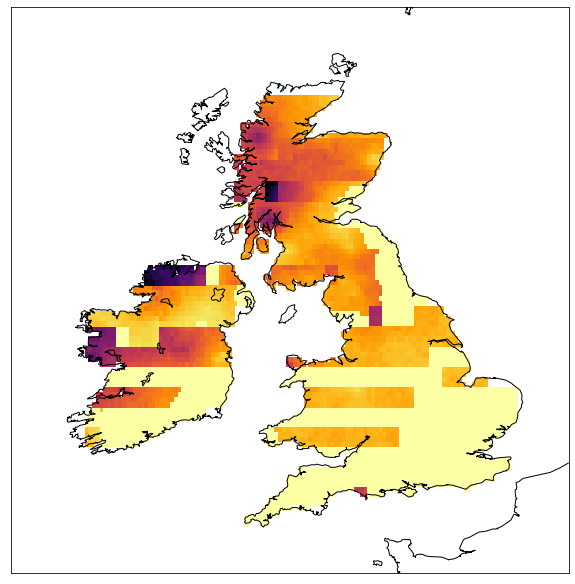

183


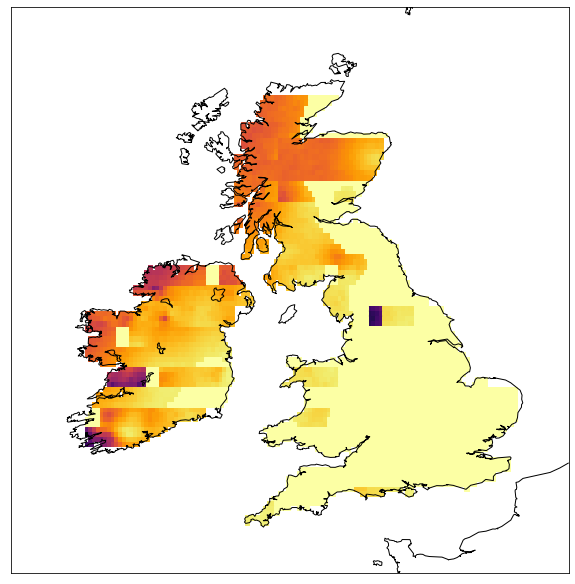

184


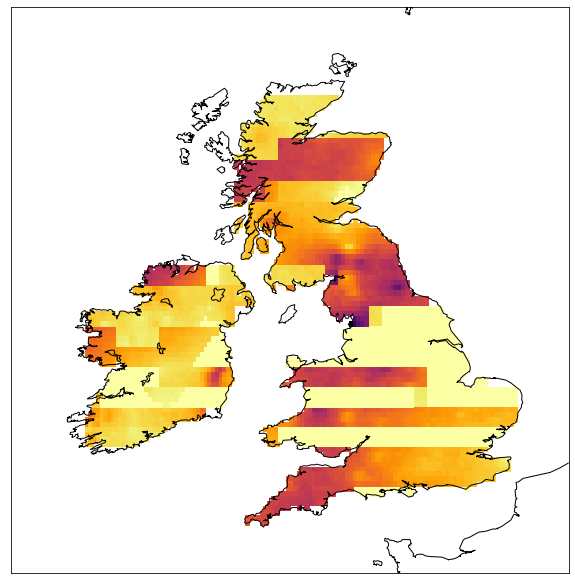

185


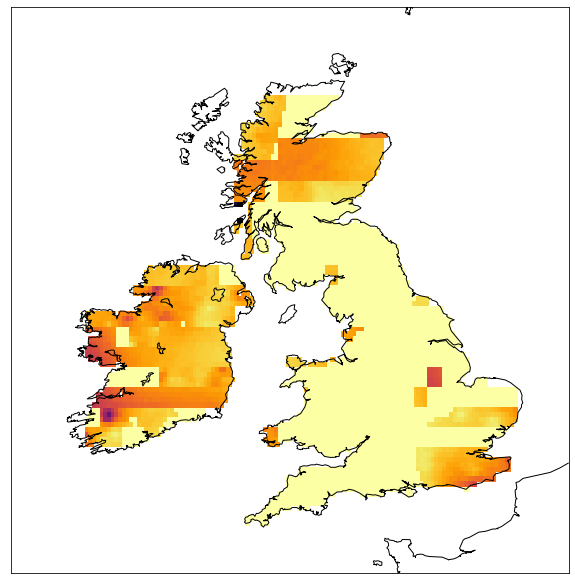

186


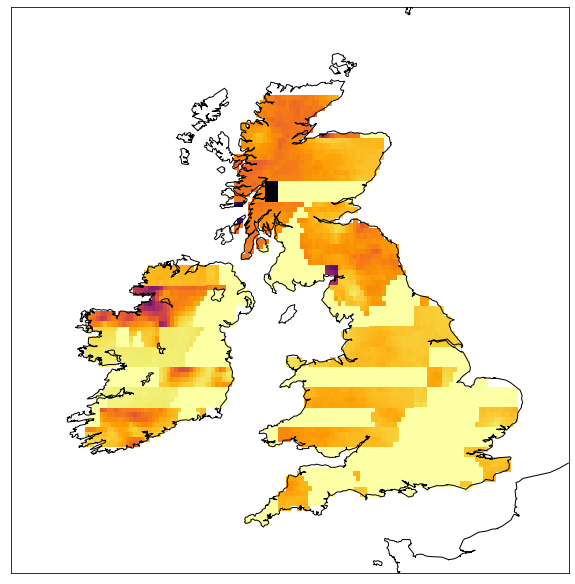

187


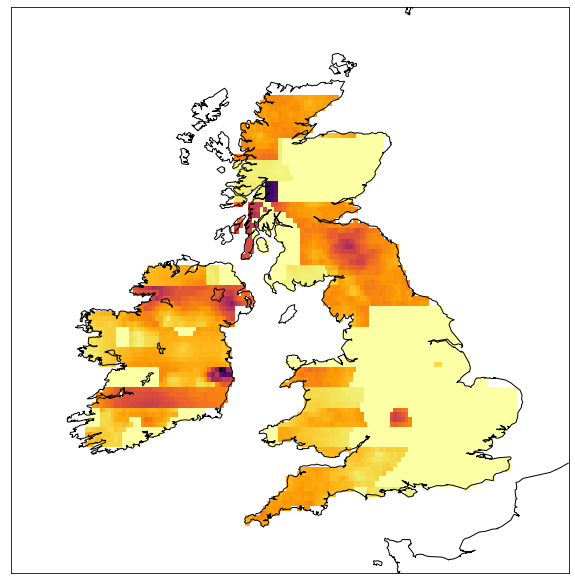

188


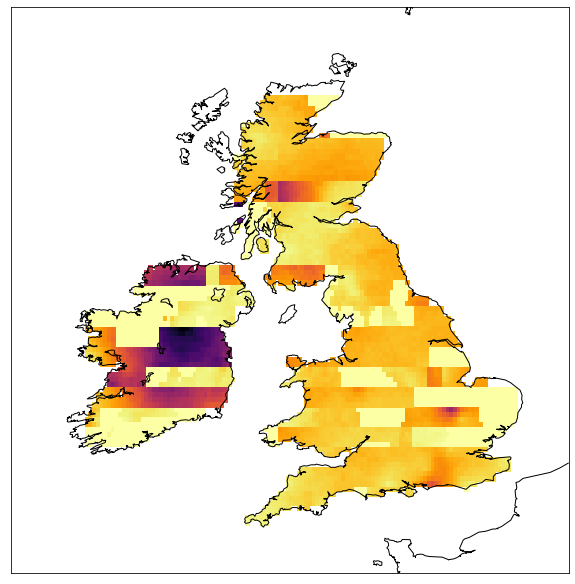

189


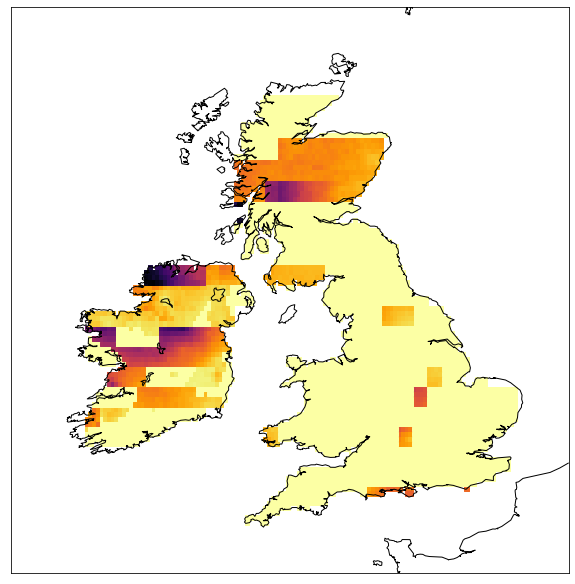

190


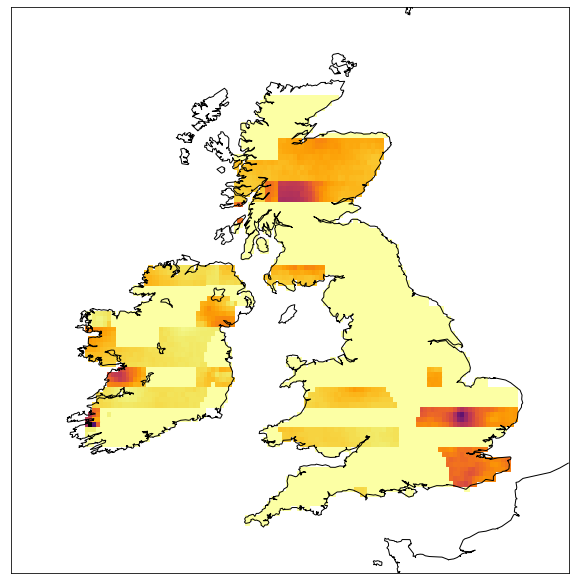

191


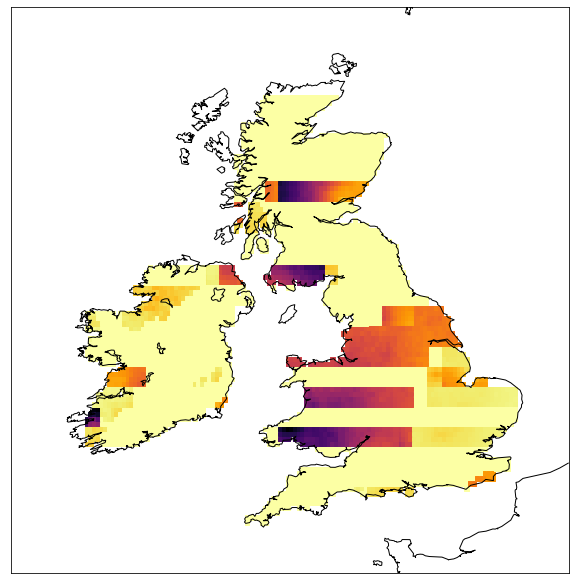

192


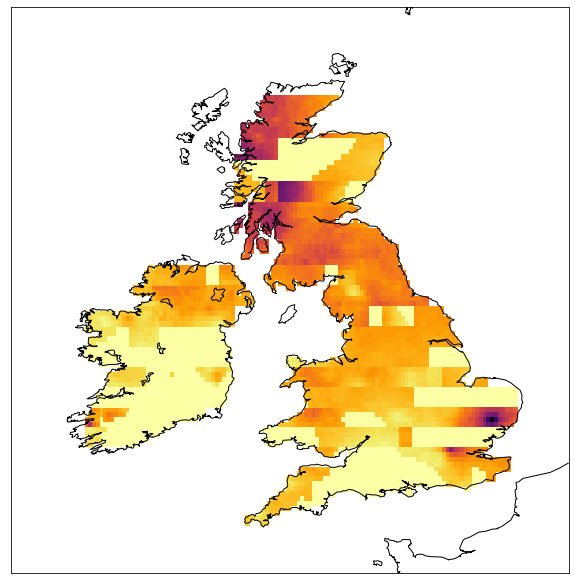

193


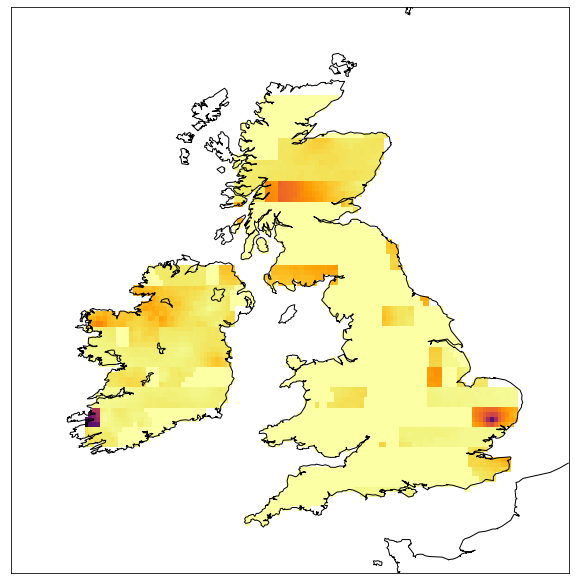

194


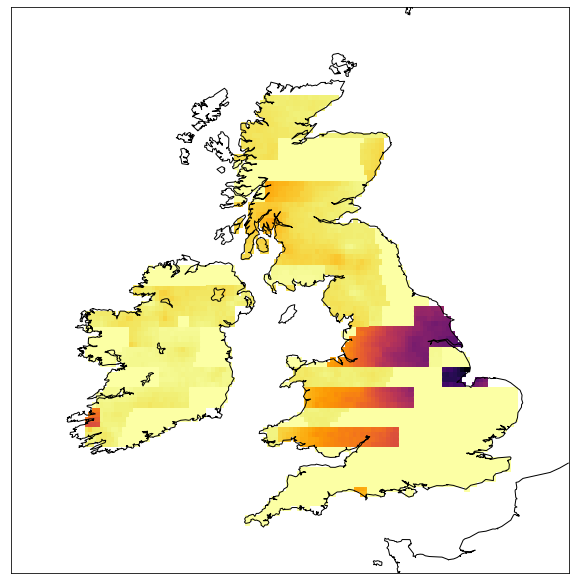

195


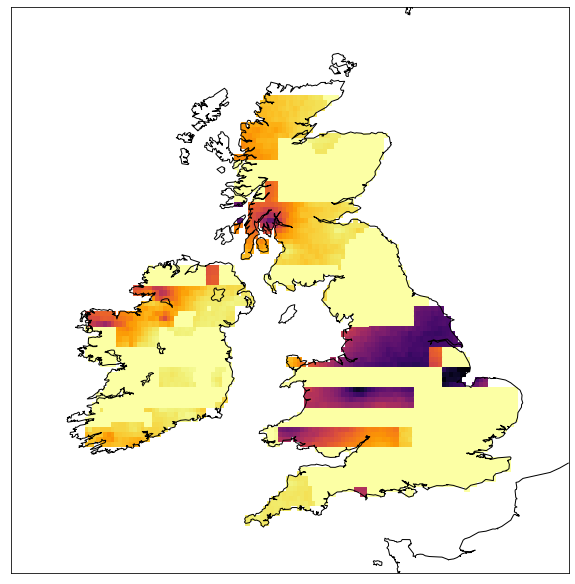

196


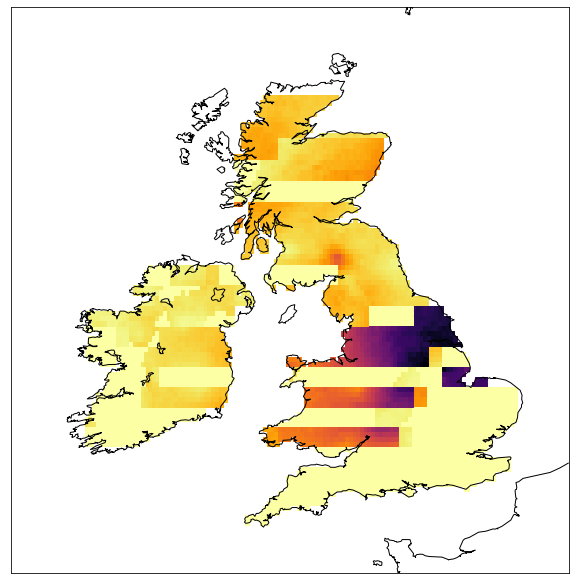

197


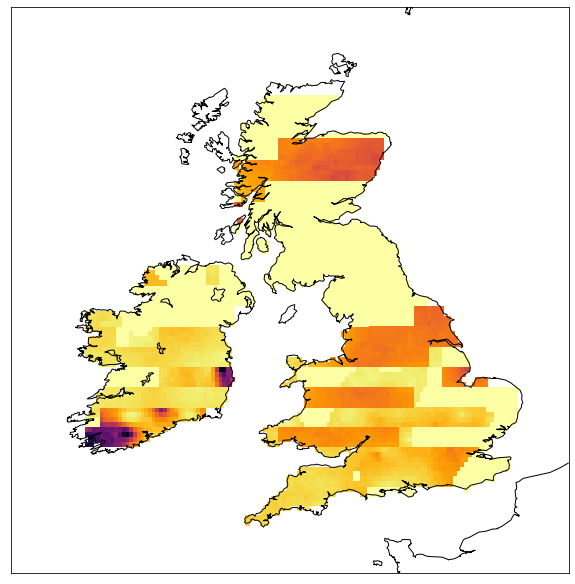

198


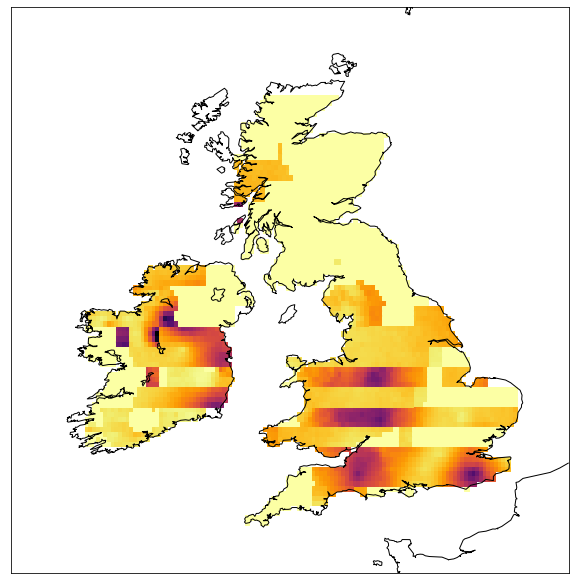

199


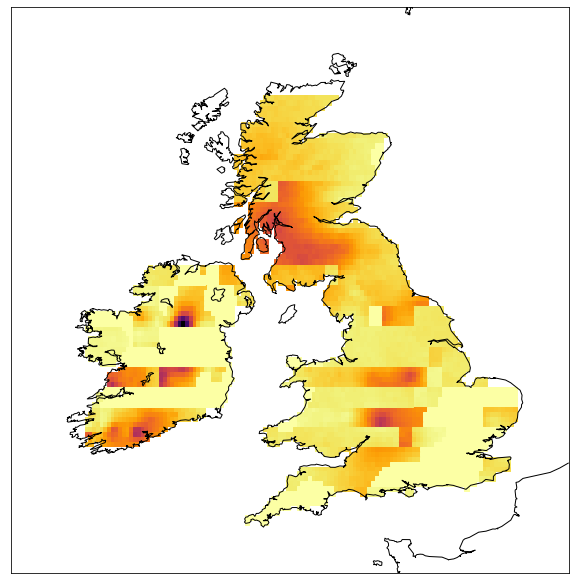

200


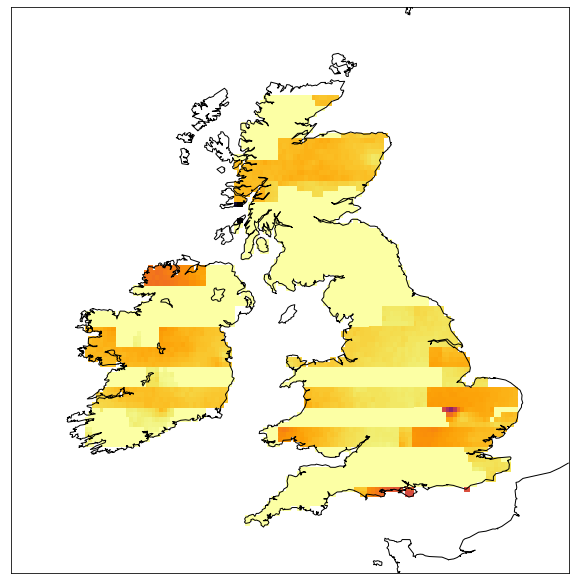

201


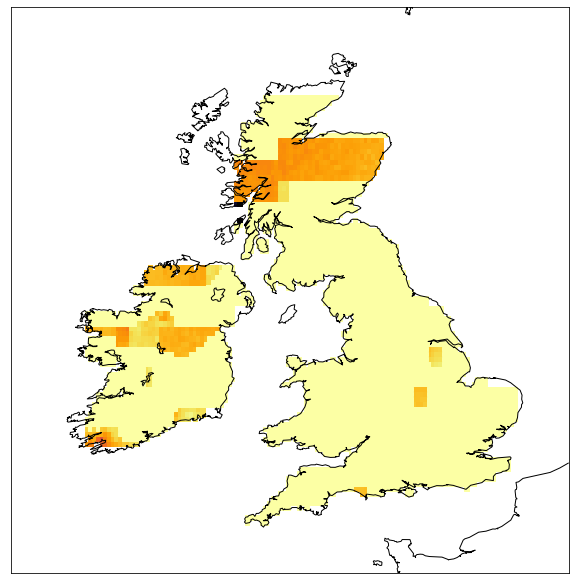

202


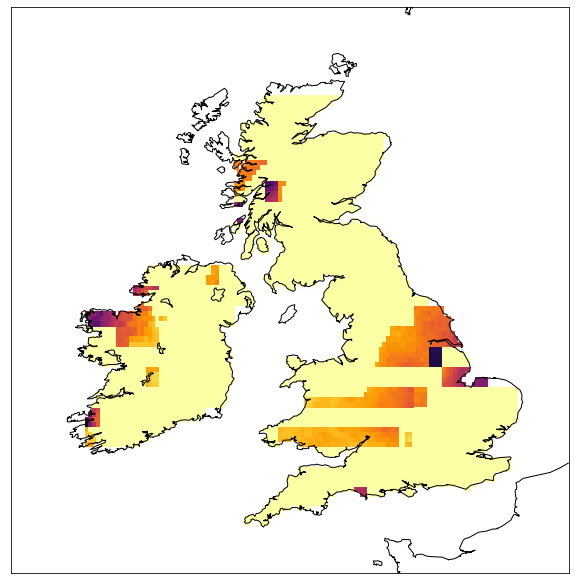

203


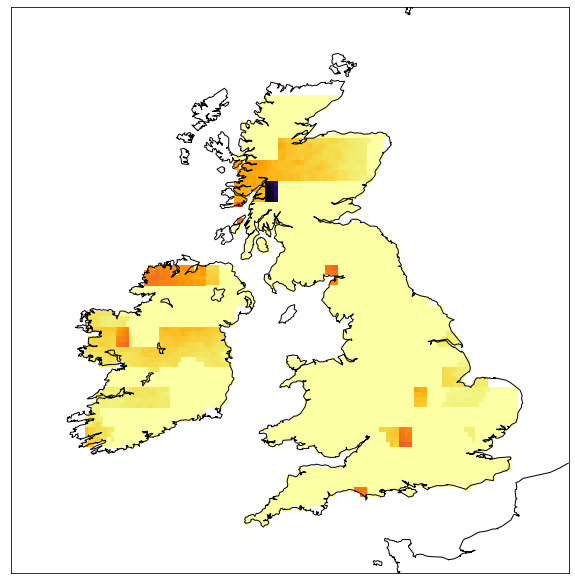

204


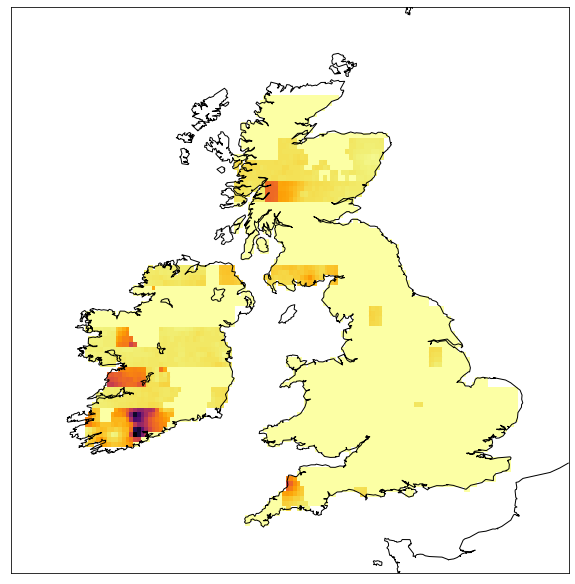

205


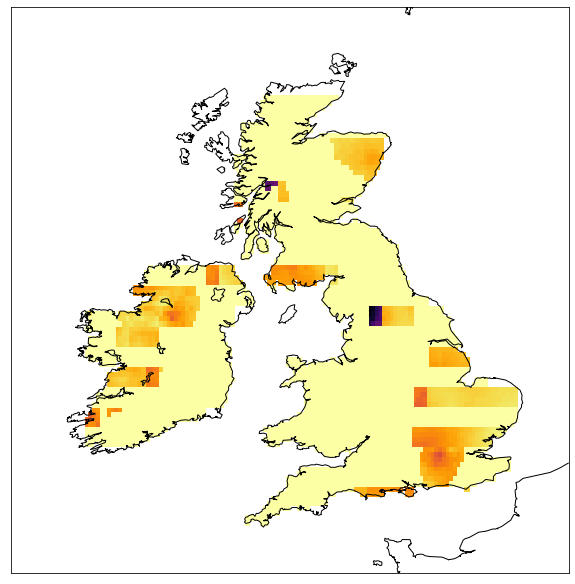

206


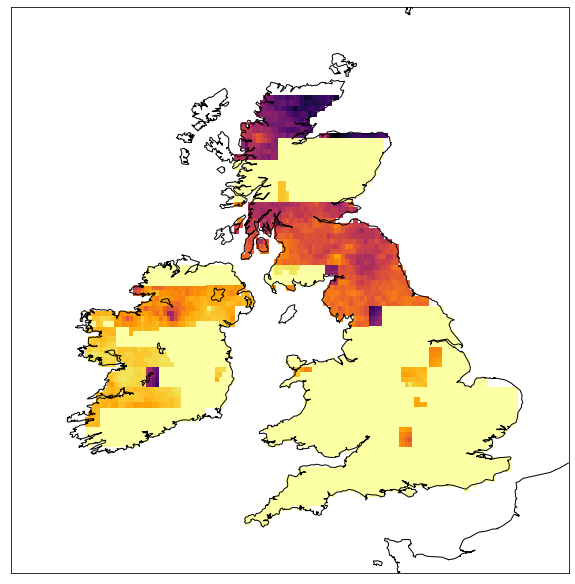

207


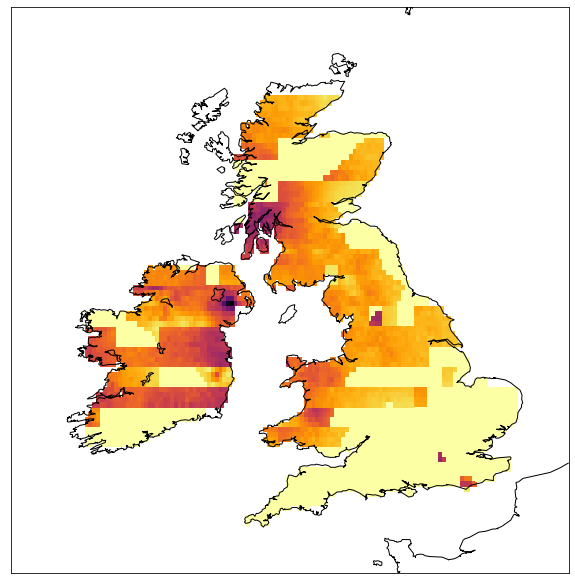

208


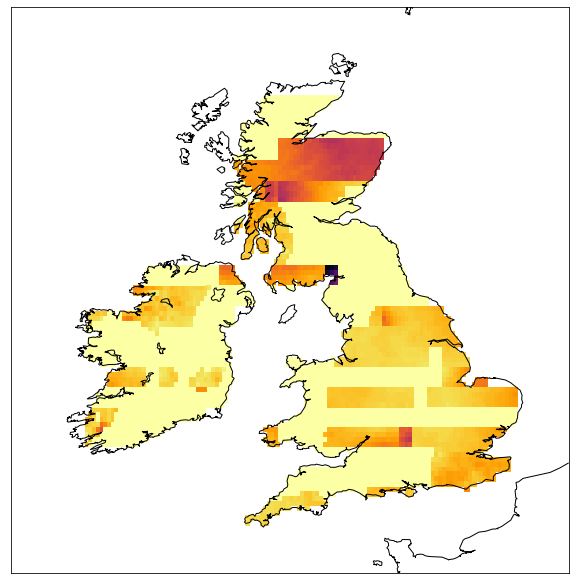

209


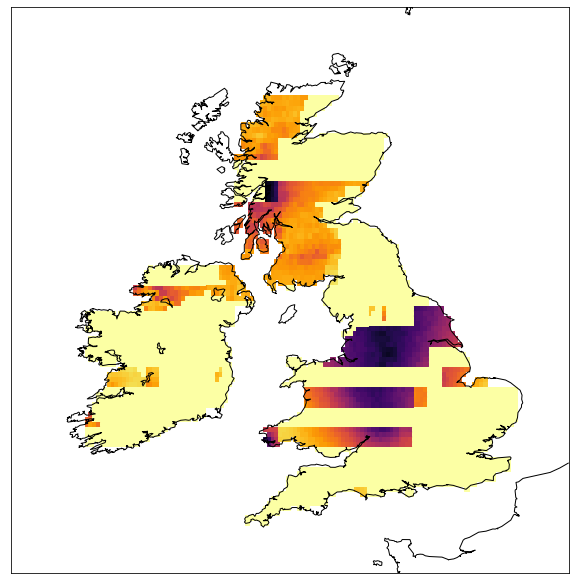

210


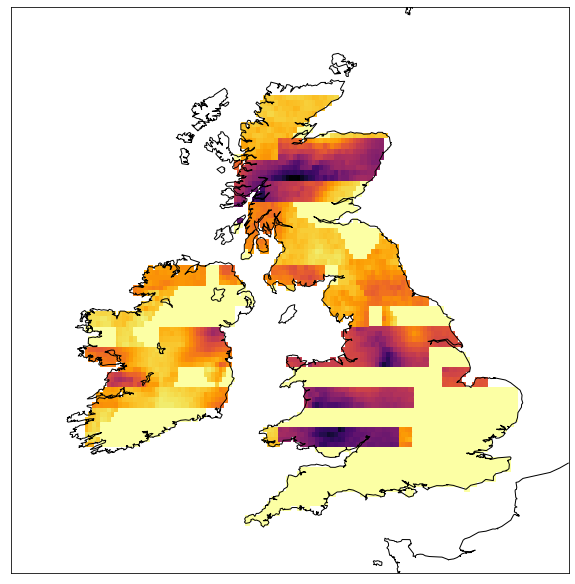

211


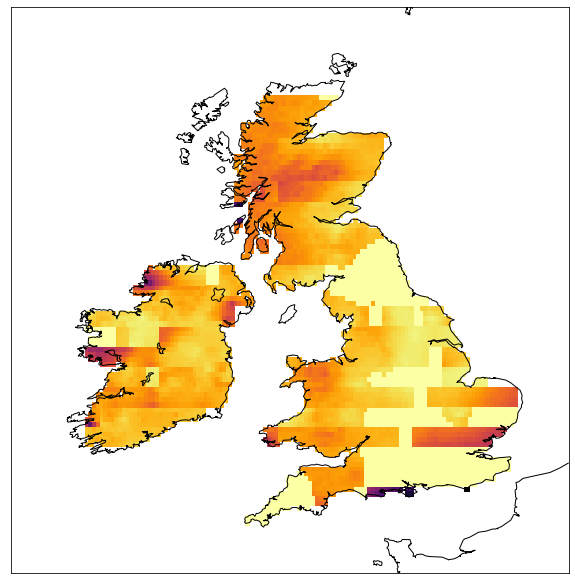

212


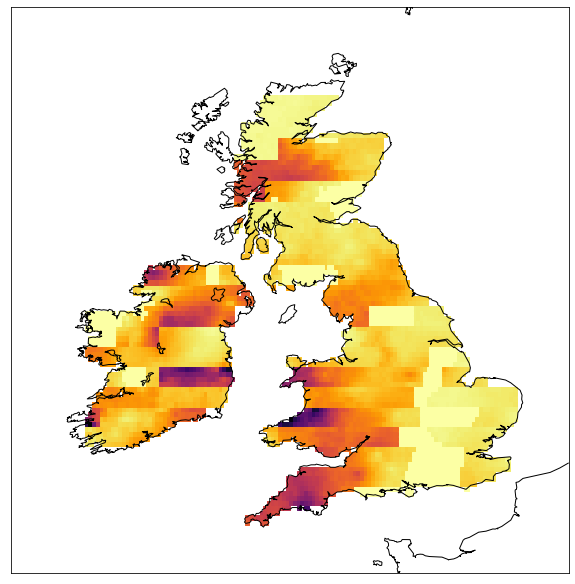

213


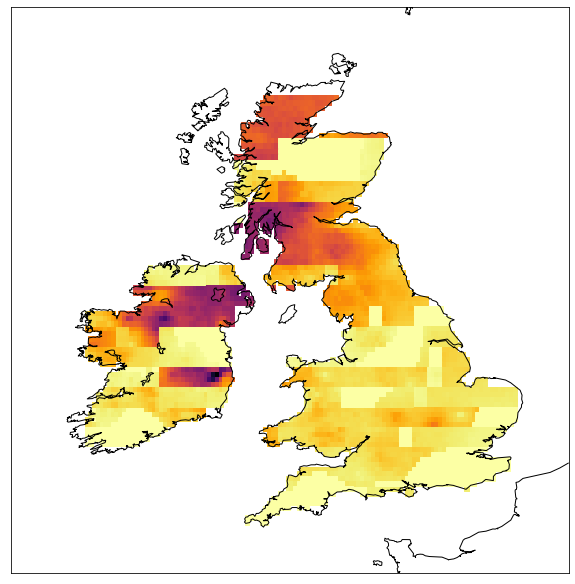

214


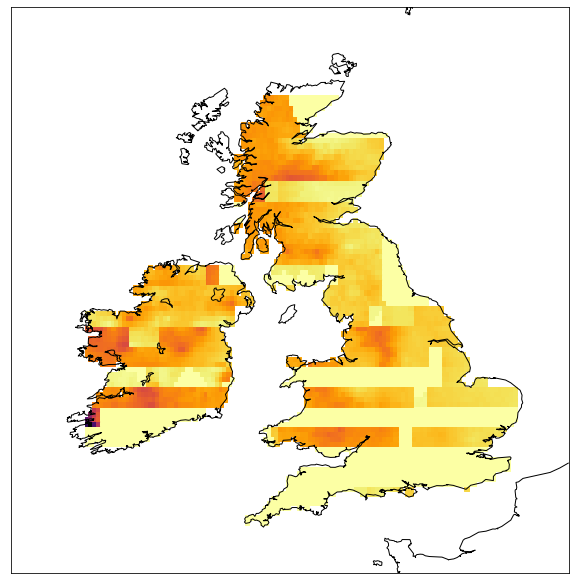

215


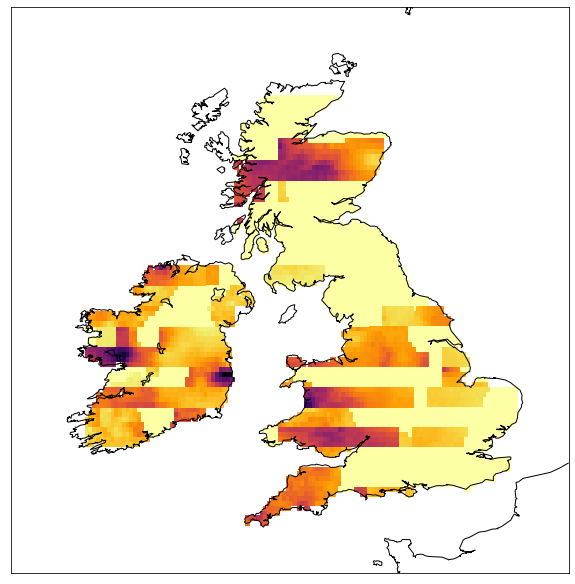

216


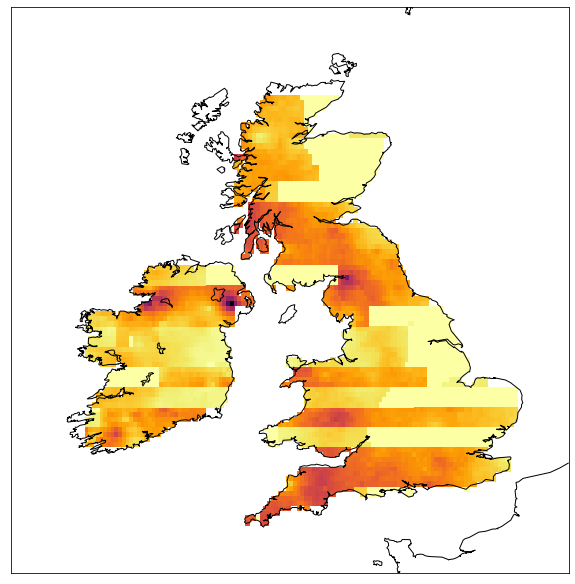

217


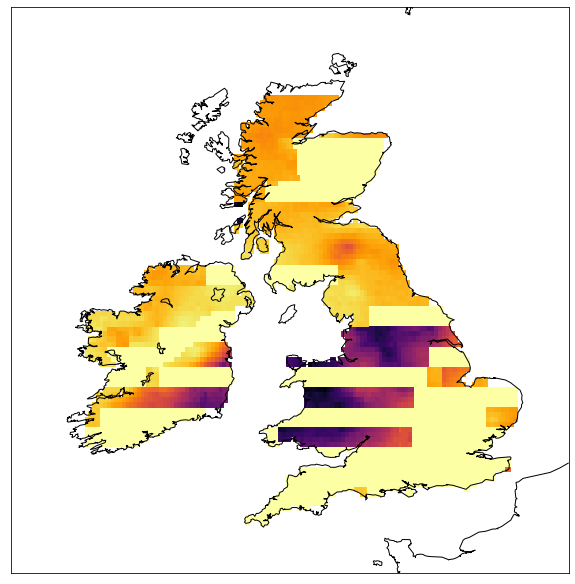

218


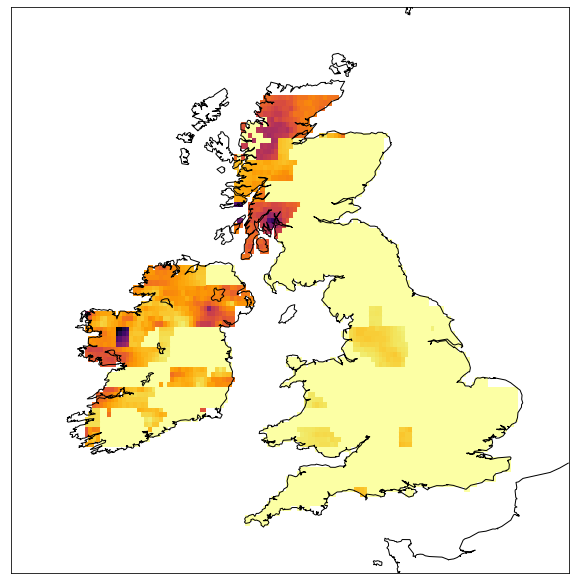

219


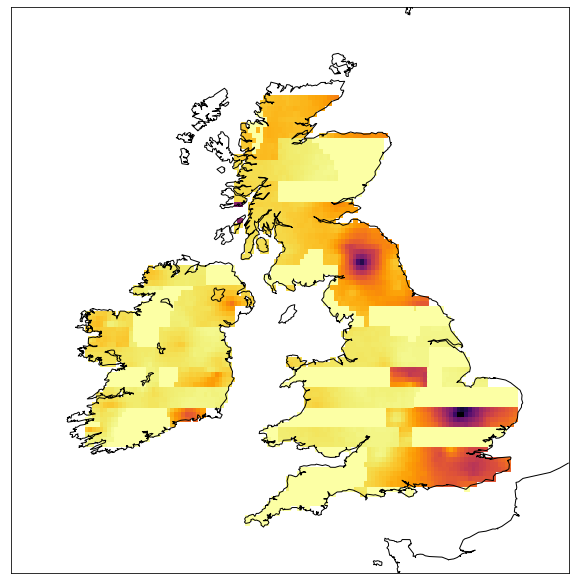

In [42]:
#locations on map 30s
for k in range(15   0,220):
    print(k)
    fig = plt.gcf()
    fig.set_size_inches(10, 20)
    dpi=300

    m.drawcoastlines()

    color = matplotlib.pyplot.cm.rainbow(np.linspace(0, 1, 4087))

    #,color=GNM_landonly[i][3][0]/28.09092,cmap='veridis'

    m.scatter(x=[m_loc_4087[i][1] for i in range(len(GNM_landonly))],y=[m_loc_4087[i][0]for i in range(len(GNM_landonly))],c=np.array([GNM_landonly[i][3][k] for i in range(len(GNM_landonly))]),cmap='inferno_r',s=20,marker='s')

    plt.show()

#Notes


Latitude and longitude of locatoins we predict for and use are icrements of 0.1 degrees, with 5 as second decimal values (0.05,0.15,0.25,...) .
